# Navigation

---

### 1. Starting the Environment

We begin by importing some necessary packages.

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.3 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
%load_ext autoreload
%autoreload 2'

In [3]:
from unityagents import UnityEnvironment
import numpy as np
from agent import Agent
from model import DQN
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import torch

# directory/file for the Banana environment (check the readme)
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

# get the default environment brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents), '\n')

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size, '\n')

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state, '\n')
state_size = len(state)
print('States have length:', state_size, '\n')

Number of agents: 1 

Number of actions: 4 

States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ] 

States have length: 37 



## 3. Initialize the Agent and train the Deep Q-Network

### 3.1 DDQN with ReplayBuffer

In this version, We implement two improvements over the popular Q-Learning algorithm:  

**1. Double Deep Q-Learning**  
The popular implementation of the Deep Q-Learning algorithm is know to overestimate the action values. It happens mostly because after taking an action under a given state, the network parameter are updated towards a target \\( Y_{DQN}\\) as given by :
\\( Y_{DQN} = R_{t} + \gamma * max Q(S_{t+1}, \alpha,\theta_{t}^{-})\\)  

The DQN uses the same weight values to select and evaluate an action under the max operator, making it more prone to result in overoptimistic value estimates.  
To prevent this, the idea behind the DDQN is exactly to separate the selection from the evaluation, using differente weights for each task.

**2. Experience Repplay**  
When the agent update its parameters incrementally, while observing the experiences, discarding data immediately after learning, two issues arise: (1) strongly correlated updates that break the i.i.d assumption of many sochastic grandient algorithms and (2) rare experiences that might be important for the agent to approximate an optimal policy are forgotten quickly.
The idea behind the experience replay is to store observed transitions for some time and then sample a batch uniformly from this buffer in order to update the network. This is shown to improve largely the algorithm's performance, as the temporal correlations are broken and rare experiences are used more than once to.

**The architecture used for both local and target network follows this architecture:**  
![](https://ibb.co/Yk57qj7)

For sake of simplicity, some parameters were chosen arbitrarily:
- Buffer size of the replay (100000 experiences)
- Batch size for updating the network (64)
- Discount factor for calculating the target( gamma = 0.95)
- Parameter for soft updating the local network (tau = 0.1)
- Learning rate for the ADAM optimizer (LR = 5e-4)
- How often to update the local network (every 4 frames)  

The algorithm converged in 426 episodes, reaching an average reward of 13.12  
The rewards plot with the moving average over 100 episodes can be seen below:

In [5]:
agent = Agent(state_size=37, action_size=4, seed=7, duelist=False, prioritize_memory=False)
scores = DQN(env=env, agent=agent, brain_name=brain_name)

Episode 100	Average Score: 1.13
Episode 200	Average Score: 4.67
Episode 300	Average Score: 8.85
Episode 400	Average Score: 10.39
Episode 500	Average Score: 12.38
Episode 526	Average Score: 13.12
Environment solved in 426 episodes!	Average Score: 13.12


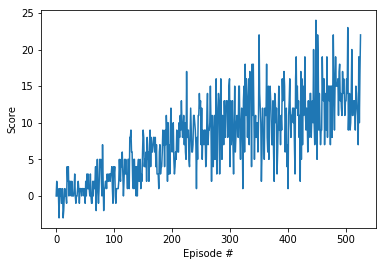

In [6]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### 3.2 Dueling DDQN with ReplayBuffer

In this version, We implement one improvement over the DDQN:

**1. Dueling Double Deep Q-Learning**  
The idea behind the dueling architecture dates back to 1993, when Baird proposed that the state-action values \\( Q(s,a)\\) should be kept separate as state and advantage values. Intuitively, this woul allow the network to learn which states are valuable or not, without having to learn the effect of each action on each state.  

The dueling network represents the state \\(V(s)\\) and advantage \\(A(s, a)\\) functions in one deep model, whose output combines them to approximate the state-action function \\(Q(s, a)\\).

**The architecture used for both local and target network follows this architecture:**  
 <img src="files/Duel_DDQN_arch.jpg">

For comparison of performance, the parameters were exactly the same as in the DDQN with ReplayBuffer.
The algorithm converged in 347 episodes, reaching an average reward of 13.03  
The rewards plot with the moving average over 100 episodes can be seen below:

In [7]:
agent = Agent(state_size=37, action_size=4, seed=7, duelist=True, prioritize_memory=False)
scores = DQN(env=env, agent=agent, brain_name=brain_name)

Episode 100	Average Score: 1.25
Episode 200	Average Score: 4.35
Episode 300	Average Score: 7.95
Episode 400	Average Score: 11.16
Episode 447	Average Score: 13.03
Environment solved in 347 episodes!	Average Score: 13.03


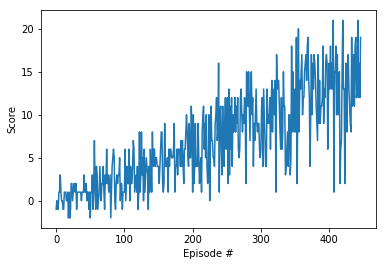

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### 3.3 Dueling DDQN with Prioritized ReplayBuffer

In this version, we implement one improvement over the Dueling DDQN:

**1. Prioritized Experience Replay**  
The key idea of PER is that the agent learns more effectively from some experiences than others. So, we increase the replay probability of experiences that offer a greater learning to the agent. However, as this information is not directly acessible, we proxy it by the measured temporal difference error.  
This introduces two new parameters: \\( alpha\\), which will determine how much prioritization will be used (if it equals zero, sampling will be uniform and son on).  
Moreover, according to the authors, this stochastic sampling introduce bias by changing the distribution in an uncontrolled fashion. This is corrected by applying importance-sampling (IS) weights, which have an exponent \\( beta \\). The IS weights will fully compensate for the non-uniform probabilities when \\(beta= 1\\).
These weights can be folded into the Q-learning update by using \\(w_i\delta_i\\) instead of \\(\delta_i\\), being \\(\delta_i\\) the TD-error.  
It's noteable that the choice of \\(\beta\\) interacts with choice of prioritization exponent \\(\alpha\\); increasing both simultaneously prioritizes sampling more aggressively at the same time as correcting for it more strongly.

In this project, a naive version of PER was implemented, as \\(\beta\\) was kept constant along the whole training. In the original paper, the authors annealead linearly \\(\beta\\) from its initial value to 1.

For comparison of performance, the parameters were exactly the same as in the previous implementations, except for the alpha and beta exponent, which were set to 1 and 0.4, respectively.

The algorithm was stopped, as it took too long to converge.

In [9]:
agent = Agent(state_size=37, action_size=4, seed=7, duelist=True, prioritize_memory=True)
scores = DQN(env=env, agent=agent, brain_name=brain_name)

Episode 19	Average Score: 0.53

KeyboardInterrupt: 

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

This is the behavior of our trained agent, after converging:  
You can also use the cell below to watch it manually.

<img src="files/smart_agent.gif">

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]

for j in range(200):
    action = agent.act(state)
                
    env_info = env.step(action)[brain_name]     
    state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    if done:
        break 
            
env.close()

### 5. Ideas for Future Work

As suggestions for further improvements:  

**-PER Improvement**  
For some reason, the current PER implementation made much more costly to run each episode, making it become much slower to converge. It's mandatory to explore what caused it and implement more efficient version;  

**- Hyperparameter optimization**
For the sake of simplicity, parameters were chosen arbitrarily, though they might have a large impact on the algorithms performance. An interesting possibility would be to perform a bayesian search, using distributed computation (using hyperopt on spark, for instance) in order to optimize the hyperparameters;  

**- Beta Annealing**
I did not anneal the beta, on the PER implementation. Some discussions suggest that this might impact the algorithm's performance;  

**- NN architecture search**
The NN architecture was also defined arbitrarily, striving for simplicity, fast convergence and reduced risk of overfitting. Again, it'd be interesting to search for an optimal architecture for the problem at hand;  

**- Rainbown DQN**
Other RL improvements could be implemented, as the Rainbown, which combine six extensions of the DQN. It'd represent the implementation of multi-step learning, Distributional RL and noisy nets. The other 3 have been implemented in this project.  

**- Asynchronous framework**
It'd be also interesting to apply a multi-threaded asynchronous variant of the algorithm, aiming to train the Q-networks reliably and with a smaller resource requirements.